In [1]:
# del bt
import importlib.util
spec = importlib.util.spec_from_file_location("baltic", '/Users/naboo/github/evogytis/baltic/baltic/baltic.py')
bt = importlib.util.module_from_spec(spec)
spec.loader.exec_module(bt)
print(bt)
from datetime import datetime
import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
from collections import defaultdict


<module 'baltic' from '/Users/naboo/github/evogytis/baltic/baltic/baltic.py'>


In [3]:

def numeric_date(dt_string):
    if not dt_string or dt_string=="None" or dt_string == 'XXXX-XX-XX':
        return None
    from calendar import isleap

    if 'XX' in dt_string:
        ambig_date = ambiguous_date_to_date_range(dt_string, "%Y-%m-%d")
        return (numeric_date(str(ambig_date[0]))+numeric_date(str(ambig_date[1])))/2;
    else:
        dt = datetime.strptime(dt_string, "%Y-%m-%d")
    days_in_year = 366 if isleap(dt.year) else 365
    try:
        res = dt.year + (dt.timetuple().tm_yday-0.5) / days_in_year
    except:
        res = None
    return res

def get_health_zone_colour(hz):
    colours_per_hz = {
        "mabalako": "#87CEFF",
        "beni": "#3b9072",
        "oicha": "#b09977",
        "butembo": "#f05129",
        "lubero": "#922428",
        "katwa": "#f5bd42",
        "kalunguta": "#966eac",
        "kyondo": "#d2202e",
        "masereka": "#621748",
        "musienene": "#b7cb95",
        "mutwanga": "#1219e9",
        "vuhovi": "#32ca29",
        "mandima": "#e3337e",
        "komanda": "#000000",
        "tchomia": "#00ff00",
        "kayna": "#37d6dc",
        "biena": "#743700",
        "manguredjipa": "#274720",
        "bunia": "#810025",
        "goma": "#FFDD00",
        "nyiragongo": "#FF8F8F",
        "rwampara": "#221959",
        "ariwara": "#BEE900",
        "mambasa": "#9FBFFF",
        "mwenga": "#C74F9D",
        "alimbongo": "#84DCC6",
        "lolwa": "#bde2e2",
        "nyakunde": "#E2BDBD"
    }
    try:
        return colours_per_hz[hz.lower()]
    except KeyError:
        return "black"


In [4]:
with open("../auspice/ebola-narrative-ms.json") as fh:
    auspice_json = json.load(fh)

ll, metadata = bt.loadJSON(
    json_object="../auspice/ebola-narrative-ms.json",
    json_translation={'name':'name','absoluteTime': lambda k: k.traits['node_attrs']['num_date']['value']},
    verbose=False)



Tree height: 1.842707
Tree length: 100.286703
annotations present

Numbers of objects in tree: 972 (180 nodes and 792 leaves)



In [5]:
# print(ll.Objects[10].name)
# print(ll.Objects[10].branchType)
# print(ll.Objects[10].absoluteTime)
# print(ll.Objects[10].name)
# print(ll.Objects[10].traits)
# print(ll.Objects[10].y)


In [6]:
def get_trait(n):
    hz = n.traits.get('node_attrs', {}).get('health_zone', {}).get('value', 'unknown')
    conf = n.traits.get('node_attrs', {}).get('health_zone', {}).get('confidence', {}).get(hz, 'unknown')
    return (hz, conf)

/Users/naboo/miniconda3/envs/augur/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


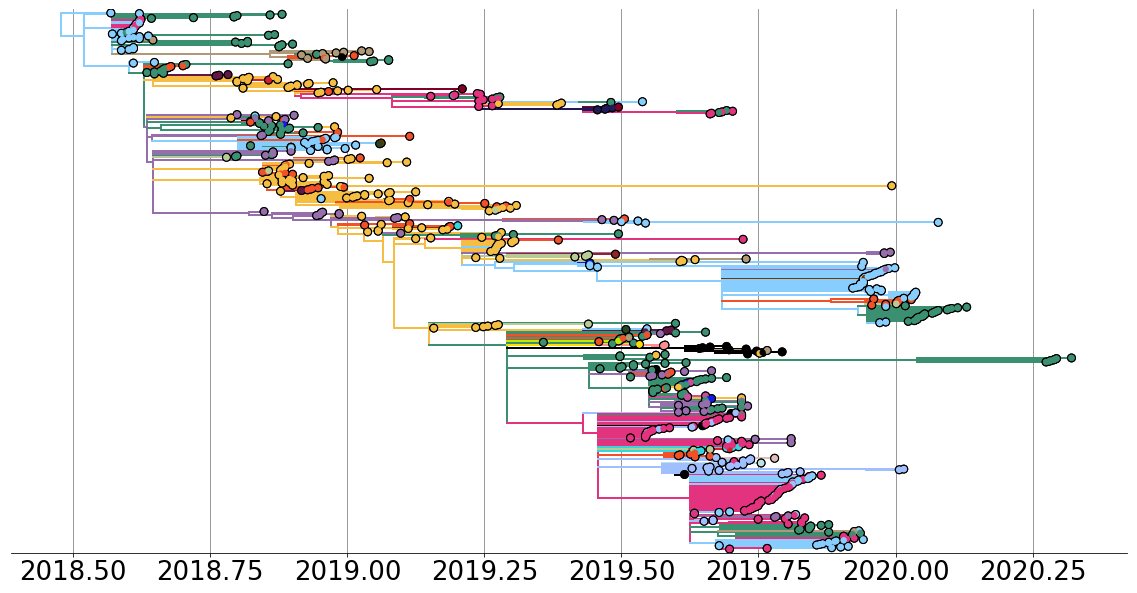

In [7]:
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

def color_by_hz(n):
    hz, conf = get_trait(n)
    hex = get_health_zone_colour(hz)
    ## TO DO -- ramp opacity according to confidence!
    return hex

x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
c_func=lambda k: 'indianred'
s_func=lambda k: 50-30*k.height/ll.treeHeight ## size of tips
z_func=lambda k: 100

cu_func=lambda k: 'k' ## for plotting a black outline of tip circles
su_func=lambda k: 2*(50-30*k.height/ll.treeHeight) ## black outline in twice as big as tip circle 
zu_func=lambda k: 99


ll.plotTree(ax,x_attr=x_attr,colour=color_by_hz) ## plot branches
ll.plotPoints(ax,x_attr=x_attr,colour=color_by_hz) ## plot circles at tips
ll.plotPoints(ax,x_attr=x_attr,colour=color_by_hz) ## plot circles under tips (to give an outline)

ax.set_ylim(-5,ll.ySpan+5)
[ax.spines[loc].set_visible(False) for loc in ['left','right','top']] ## no axes

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',labelsize=26)
ax.set_yticklabels([])
plt.show()

In [8]:

print(ll.root.absoluteTime, ll.root.parent.index)

## TODO -- define initial zoonosis
# ll.root.parent.traits[traitName]='ancestor' ## add fake trait to root of the tree

subtype_trees = defaultdict(list)


for n_idx, n in enumerate(ll.Objects[:]):

    node_trait = get_trait(n)[0]
    if n_idx==0:
        parent_trait = "zoonosis"
    else:
        parent = n.parent
        parent_trait = get_trait(parent)[0]
    
    if node_trait != parent_trait and node_trait != "unknown" and parent_trait != "unknown":
        is_node_in_subtree = lambda nn: get_trait(nn)[0]==node_trait
        subtree=ll.subtree(n, traverse_condition=is_node_in_subtree) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
        subtree.traverse_tree()
        subtree.drawTree(verbose=False)
        subtree.sortBranches()
        print(f"subtree resulting from {parent_trait} -> {node_trait} switch. nObjects: {len(subtree.Objects)}, duration: {subtree.treeHeight}")
        if n_idx==0:
            print("\tDefining zoonosis as happening at overall TMRCA")
            subtree.root.parent.absoluteTime = ll.root.absoluteTime
        subtype_trees[node_trait].append((parent_trait, subtree))


print('Done!')


2018.4783316820024 Root
subtree resulting from zoonosis -> Mabalako switch. nObjects: 37, duration: 0.16961352347698266
	Defining zoonosis as happening at overall TMRCA
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Beni switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Beni switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Beni switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subtree resulting from Mabalako -> Mandima switch. nObjects: 1, duration: 0
subt

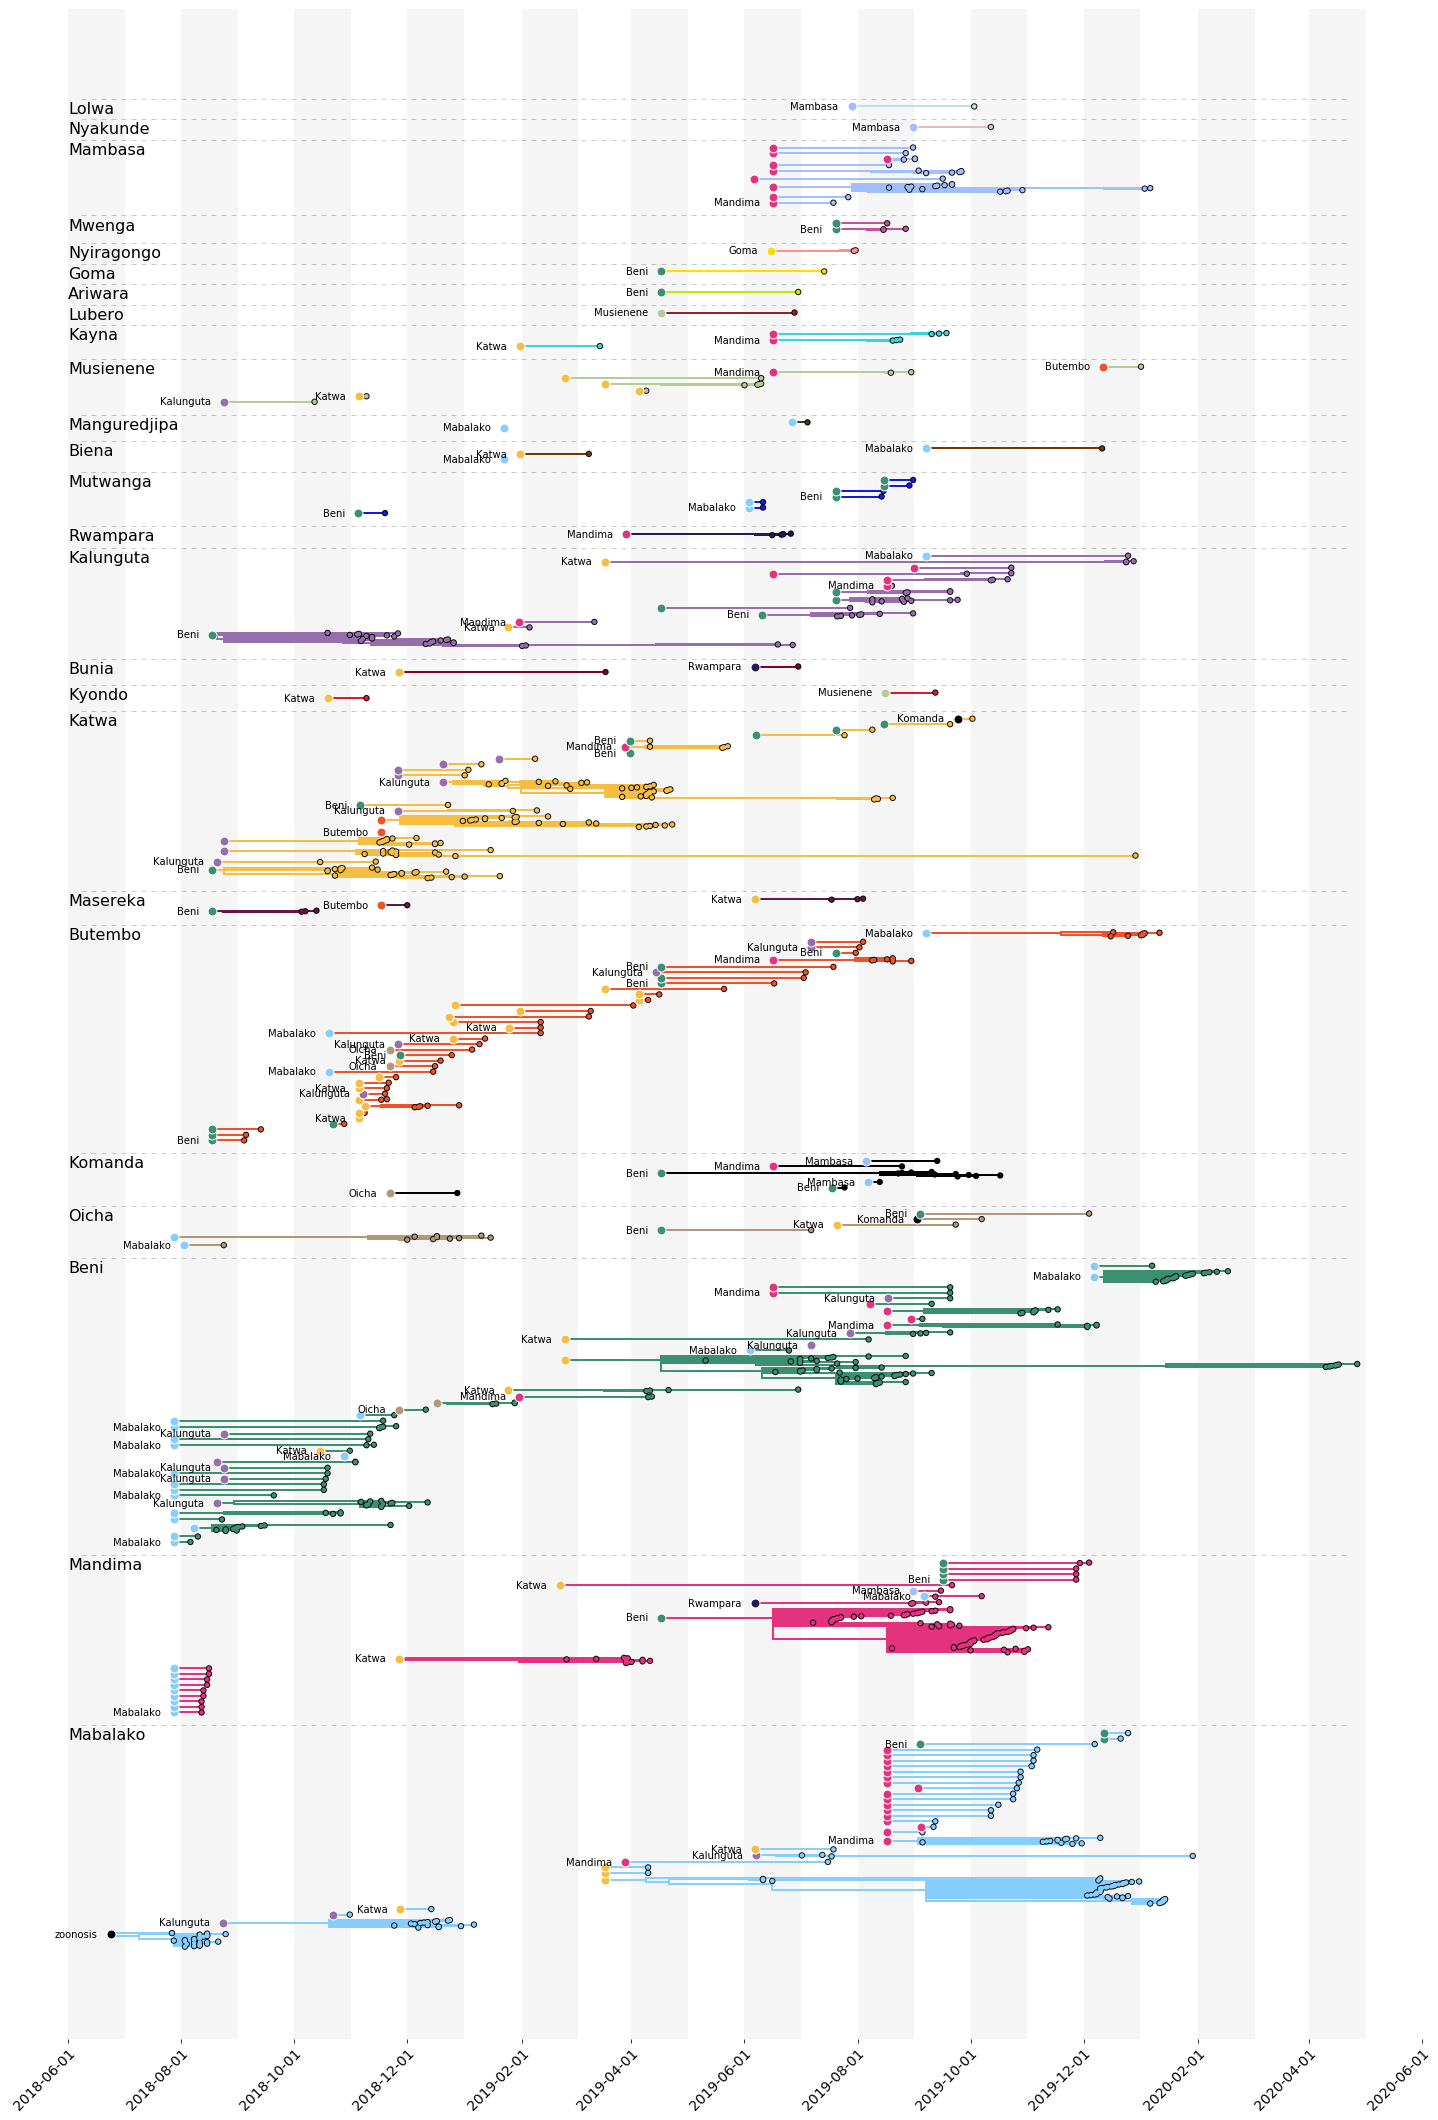

In [9]:
fig,ax = plt.subplots(figsize=(20,30), facecolor='w')

cumulative_y=0

for subtype in subtype_trees.keys():

    subtrees = sorted(subtype_trees[subtype], key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)), reverse=True)
        
    ## iterate over extracted subtrees sorted according to their root height and their size
    for idx, bt_data in enumerate(subtrees):
        y_attr=lambda k: k.y+cumulative_y # shift subtrees appropriately
        origin, loc_tree = bt_data ## get origin of subtree, subtree itself
        
        loc_tree.plotTree(ax,x_attr=x_attr,colour=color_by_hz, y_attr=y_attr) ## plot branches
        loc_tree.plotPoints(ax,x_attr=x_attr,colour=color_by_hz, y_attr=y_attr, size=20) ## plot circles at tip
        # loc_tree.plotPoints(ax,x_attr=x_attr,colour=color_by_hz, y_attr=y_attr, size) ## plot circles under tips (to give an outline)

        ## add big circle at base of tree to indicate origin
        parentX = loc_tree.root.parent.absoluteTime
        ax.scatter(
            x=parentX, 
            y=loc_tree.root.y+cumulative_y,
            s=80,
            zorder=200,
            facecolor=get_health_zone_colour(origin),
            edgecolor='w',
            lw=1,
        )
        # show label unless the previously drawn subtree (in same HZ) had the same source...
        if idx==0 or subtrees[idx-1][0]!=origin:
            ax.text(
                x=parentX-1/52,
                y=loc_tree.root.y+cumulative_y,
                s=origin,
                ha="right", va="center",
                fontsize=10,
                zorder=210,
            )
        
        cumulative_y+=loc_tree.ySpan+10 ## increment y displacement
    
    # after drawing the subtrees, label the HZ where they resided above them
    if len(subtrees):
        ax.axhline(y=cumulative_y+5, xmin=0.05, xmax=0.95, dashes=(10,10), alpha=0.4, c='k', lw=0.5)

        ax.text(
            x = numeric_date('2018-06-01'), y=cumulative_y,
            s = subtype,
            ha="left", va="top", fontsize=16
        )
        cumulative_y+=30 ## extra increment y displacement between HZs
        
        

def makeNiceBackground():
    n_months_shaded = 1 # units: months
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    xDates=['2018-%02d-01'%x for x in range(5,13)]
    xDates+=['2019-%02d-01'%x for x in range(1,13)]
    xDates+=['2020-%02d-01'%x for x in range(1,7)]

    ax.set_xlim(numeric_date(xDates[0]), numeric_date(xDates[-1]))
    ticks = []
    labels = []
    # background shading
    for x in range(0, len(xDates), n_months_shaded):
        if x%2:
            ax.axvspan(numeric_date(xDates[x]), numeric_date(xDates[x])+n_months_shaded/float(12), facecolor='k', edgecolor='none', alpha=0.04)
            ticks.append(numeric_date(xDates[x]))
            labels.append(xDates[x])
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontsize=14, rotation=45, ha="right", rotation_mode="anchor")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])



makeNiceBackground()
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.05)
plt.savefig("exploded_tree.png", format="png", pad_inches=0)
plt.show()
